## Assessing Market Inefficiency Based on Volatility

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from openbb import obb
from scipy.stats import spearmanr

In [4]:
obb.user.preferences.output_type = "dataframe"

Define the stock symbols

In [5]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "GOOG", "META"]

Fetch historical price data for the defined symbols from 2015-01-01 to 2022-12-31 using the "yfinance" provider

In [6]:
data = obb.equity.price.historical(
    symbols, start_date="2015-01-01", end_date="2022-12-31", provider="yfinance"
)

Select relevant columns from the data

In [7]:
prices = data[["high", "low", "close", "volume", "symbol"]]

Filter out symbols with less than 2 years of data

In [8]:
nobs = prices.groupby("symbol").size()
mask = nobs[nobs > 2 * 12 * 21].index
prices = prices[prices.symbol.isin(mask)]

Reorder levels and sort index

In [9]:
prices = (
    prices.set_index("symbol", append=True)
    .reorder_levels(["symbol", "date"])
    .sort_index(level=0)
).drop_duplicates()

Define a function to calculate Parkinson volatility

In [10]:
def parkinson(data, window=14, trading_days=252):
    rs = (1.0 / (4.0 * np.log(2.0))) * ((data.high / data.low).apply(np.log)) ** 2.0

    def f(v):
        return (trading_days * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    return result.sub(result.mean()).div(result.std())

Calculate volatility using the Parkinson method and add it to the 'prices' DataFrame

In [11]:
prices["vol"] = prices.groupby("symbol", group_keys=False).apply(parkinson)
prices.dropna(inplace=True)

Calculate lagged returns and targets for different time periods

In [12]:
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = prices.groupby(level="symbol").close.pct_change(lag)

In [13]:
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = prices.groupby(level="symbol")[f"return_{t}d"].shift(-t)

In [14]:
display(prices)

high         low       close   volume       vol  \
symbol date                                                                
CDE    2015-01-22    6.430000    6.150000    6.310000  3404900  0.502345   
       2015-01-23    6.250000    5.930000    5.990000  2234000  0.466274   
       2015-01-26    6.130000    5.690000    6.110000  2149800  0.512970   
       2015-01-27    6.420000    6.120000    6.320000  3697700  0.508157   
       2015-01-28    6.360000    5.890000    5.990000  2668300  0.488355   
...                       ...         ...         ...      ...       ...   
UNH    2022-12-23  531.309998  522.900024  531.309998  1292300 -0.477275   
       2022-12-27  535.840027  529.849976  531.989990  1596700 -0.480026   
       2022-12-28  538.150024  527.729980  528.450012  1694200 -0.429139   
       2022-12-29  533.679993  528.859985  529.880005  1379700 -0.450629   
       2022-12-30  530.500000  524.840027  530.179993  1849600 -0.491592   

                   return_1d  return_5d  return_10d  return_21d  return_42d  \
symbol date                                                                   
CDE    2015-01-22        NaN        NaN         NaN         NaN         NaN   
       2015-01-23  -0.050713        NaN         NaN         NaN         NaN   
       2015-01-26   0.020033        NaN         NaN         NaN         NaN   
       2015-01-27   0.034370        NaN         NaN         NaN         NaN   
       2015-01-28  -0.052215        NaN         NaN         NaN         NaN   
...                      ...        ...         ...         ...         ...   
UNH    2022-12-23   0.008006   0.014531   -0.014633    0.003020   -0.016493   
       2022-12-27   0.001280   0.016024   -0.025409   -0.010472   -0.020583   
       2022-12-28  -0.006654   0.015840   -0.018152   -0.007177   -0.024640   
       2022-12-29   0.002706   0.004436   -0.015752    0.003561   -0.038749   
       2022-12-30   0.000566   0.005862    0.004738   -0.032094   -0.044979   

                   return_63d  target_1d  target_5d  target_10d  target_21d  \
symbol date                                                                   
CDE    2015-01-22         NaN  -0.050713  -0.058637    0.145800   -0.083994   
       2015-01-23         NaN   0.020033   0.051753    0.170284   -0.083472   
       2015-01-26         NaN   0.034370   0.045826    0.189853   -0.094926   
       2015-01-27         NaN  -0.052215   0.036392    0.136076   -0.115506   
       2015-01-28         NaN  -0.008347   0.188648    0.158598   -0.025042   
...                       ...        ...        ...         ...         ...   
UNH    2022-12-23    0.045145   0.001280        NaN         NaN         NaN   
       2022-12-27    0.046462  -0.006654        NaN         NaN         NaN   
       2022-12-28    0.028233   0.002706        NaN         NaN         NaN   
       2022-12-29    0.041369   0.000566        NaN         NaN         NaN   
       2022-12-30    0.049778        NaN        NaN         NaN         NaN   

                   target_42d  target_63d  
symbol date                                
CDE    2015-01-22   -0.133122   -0.118859  
       2015-01-23   -0.118531   -0.136895  
       2015-01-26   -0.147300   -0.067103  
       2015-01-27   -0.202532   -0.106013  
       2015-01-28   -0.191987   -0.086811  
...                       ...         ...  
UNH    2022-12-23         NaN         NaN  
       2022-12-27         NaN         NaN  
       2022-12-28         NaN         NaN  
       2022-12-29         NaN         NaN  
       2022-12-30         NaN         NaN  

[20010 rows x 17 columns]

Plot a joint plot of volatility vs. 1-day target return

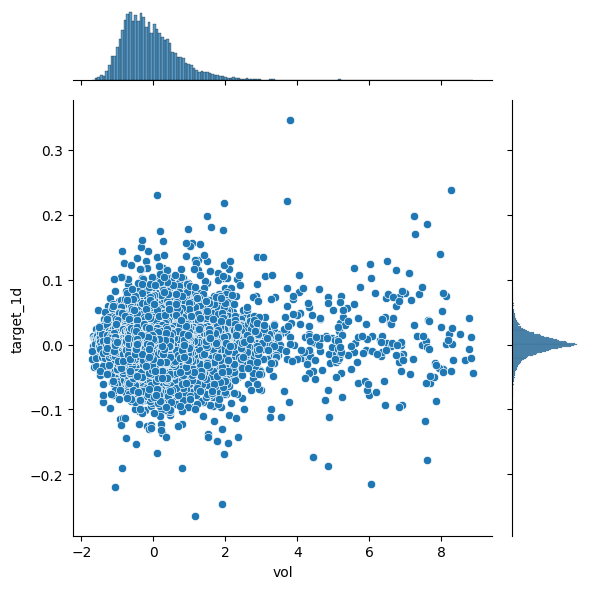

In [15]:
target = "target_1d"
metric = "vol"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()

Calculate and display the Spearman rank correlation and p-value

In [16]:
df = prices[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
display(f"{r:,.2%} ({p:.2%})")

'1.59% (2.46%)'

Display the first 10 rows of 'prices' DataFrame for the symbol "NEM"

In [17]:
d = prices.loc["NEM"].head(10)
display(d)

,high,low,close,volume,vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,target_42d,target_63d
date,,,,,,,,,,,,,,,,,
2015-01-22,24.690001,23.980000,24.290001,13132700,1.021514,NaN,NaN,NaN,NaN,NaN,NaN,-0.005764,-0.004940,0.021820,0.068752,-0.058872,-0.034582
2015-01-23,24.430000,23.670000,24.150000,12056800,0.976773,-0.005764,NaN,NaN,NaN,NaN,NaN,0.014079,0.041408,-0.004141,0.068737,-0.069151,0.034369
2015-01-26,24.629999,23.350000,24.490000,11189200,1.059908,0.014079,NaN,NaN,NaN,NaN,NaN,0.026541,0.025316,0.004900,0.063699,-0.095141,0.044916
2015-01-27,25.250000,24.530001,25.139999,10774500,0.948081,0.026541,NaN,NaN,NaN,NaN,NaN,-0.035004,-0.020684,-0.029037,0.046539,-0.115752,0.048131
2015-01-28,25.049999,24.030001,24.260000,11251300,0.962112,-0.035004,NaN,NaN,NaN,NaN,NaN,-0.003710,0.023083,-0.004946,0.085326,-0.092333,0.091509
2015-01-29,24.340000,23.420000,24.170000,8850000,1.016856,-0.003710,-0.004940,NaN,NaN,NaN,NaN,0.040546,0.026893,0.014067,0.071163,-0.101779,0.095987
2015-01-30,25.219999,23.920000,25.150000,11594400,1.139381,0.040546,0.041408,NaN,NaN,NaN,NaN,-0.001590,-0.043738,-0.014712,0.018688,-0.096620,0.053280
2015-02-02,25.200001,24.559999,25.110001,7497000,1.109351,-0.001590,0.025316,NaN,NaN,NaN,NaN,-0.019514,-0.019912,-0.036639,0.003186,-0.110315,0.037435
2015-02-03,25.070000,24.139999,24.620001,9038100,0.957277,-0.019514,-0.020684,NaN,NaN,NaN,NaN,0.008123,-0.008530,0.004874,0.027620,-0.082859,0.054021


Display the metric and target columns

In [18]:
display(df[metric])
display(df[target])

symbol  date      
CDE     2015-01-22    0.502345
        2015-01-23    0.466274
        2015-01-26    0.512970
        2015-01-27    0.508157
        2015-01-28    0.488355
                        ...   
UNH     2022-12-22   -0.464863
        2022-12-23   -0.477275
        2022-12-27   -0.480026
        2022-12-28   -0.429139
        2022-12-29   -0.450629
Name: vol, Length: 20000, dtype: float64

symbol  date      
CDE     2015-01-22   -0.050713
        2015-01-23    0.020033
        2015-01-26    0.034370
        2015-01-27   -0.052215
        2015-01-28   -0.008347
                        ...   
UNH     2022-12-22    0.008006
        2022-12-23    0.001280
        2022-12-27   -0.006654
        2022-12-28    0.002706
        2022-12-29    0.000566
Name: target_1d, Length: 20000, dtype: float64

Display the correlation and p-value

In [17]:
display(r, p)

0.022894821944437795

0.003777781841261211

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.